In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_grid(images, labels):
    fig, axs = plt.subplots(images.shape[0], images.shape[1], figsize=(10,10))
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            axs[i, j].imshow(images[i, j])
            try:
                axs[i, j].set_title(labels[i][j])
            except:
                pass
            axs[i, j].axis('off')

def show_images(data, samples=10):
    fig, axes = plt.subplots(1, samples, figsize=(20, 2))
    indices = np.random.randint(0, len(data), samples)
    for i, idx in enumerate(indices):
        image, label = data[idx]
        image = image.squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        # print(image.squeeze().shape)
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

# I only had a cpu during training, so I didn't provide a GPU option
device = torch.device('cpu')

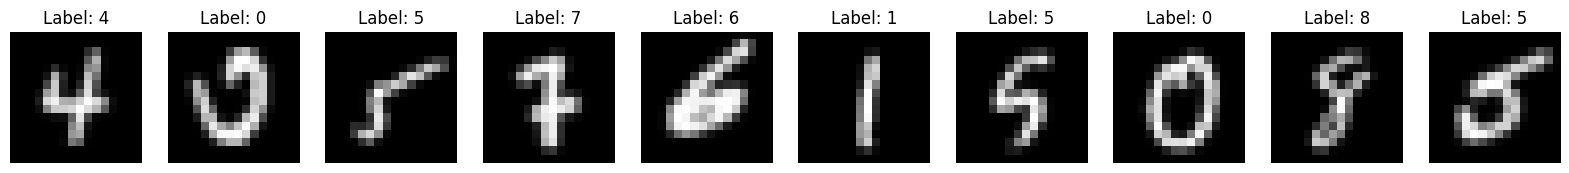

In [3]:
# Reshape the images to 16x16
transform = transforms.Compose([transforms.Resize((16, 16)), 
                                transforms.ToTensor(),
                                transforms.Lambda(lambda t: (t * 2) - 1)]
                                )

data = MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = DataLoader(data, batch_size=64, shuffle=True)

show_images(data)

In [4]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, t, device='cpu'):
    # Returns noisy version of the image at a time stamp
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define time steps
T = 500
betas = linear_beta_schedule(timesteps=T)

# Initialize terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

print(alphas.shape)

torch.Size([500])


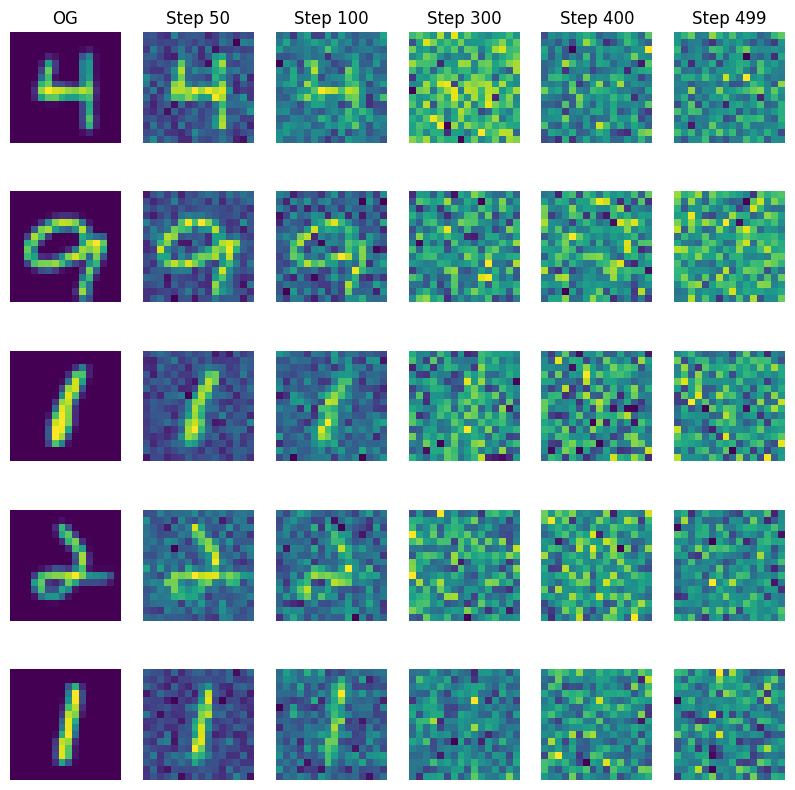

In [7]:
def get_noised_images(images, step, alphas_comulative_product):
    sqr_cp_alphas = np.sqrt(alphas_comulative_product[step])
    sqr_one_minus_cp_alphas = np.sqrt(1-alphas_comulative_product[step])
    eps  = torch.randn_like(images)
    noised_images = sqr_cp_alphas*images + sqr_one_minus_cp_alphas*eps
    return noised_images, eps
    
images, labels = next(iter(data_loader))
image = images[0:5]
noised_image_50, _ = get_noised_images(image, 50, alphas_cumprod)
noised_image_100, _ = get_noised_images(image, 100, alphas_cumprod)
noised_image_300, _ = get_noised_images(image, 300, alphas_cumprod)
noised_image_400, _ = get_noised_images(image, 400, alphas_cumprod)
noised_image_499, _ = get_noised_images(image, 499, alphas_cumprod)

images_concat = torch.cat((image, noised_image_50, noised_image_100, noised_image_300, noised_image_400, noised_image_499), dim=1)
# Plot the images
labels = [['OG', 'Step 50', 'Step 100', 'Step 300', 'Step 400', 'Step 499']]
plot_grid(images_concat, labels)